In [4]:
import xarray as xr
from scipy.interpolate import griddata
import numpy as np
from xgcm import Grid
import time
import gsw
from geopy import distance
import glob
import copy as cp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [5]:
# Cst
f0 = 2*7.2921e-5*np.sin(80*np.pi/180)
R = 6356800 #m
Seas = ['W', 'S', 'E', 'A']

In [6]:
def sigma0(As, ct):
    return gsw.density.sigma0(As, ct)+1000

def delta_sigma0(As, ct, sigma_0):
    return gsw.density.sigma0(As, ct)+1000 - sigma_0

def sigma1(As, ct):
    return gsw.density.sigma1(As, ct)+1000

def delta_sigma1(As, ct, sigma_1):
    return gsw.density.sigma1(As, ct)+1000 - sigma_1


# Functions

## WOA 

In [5]:
def WOA_M_Q_moy_sigma(ListeT, ListeS, ListeR, deta, Rho_Vals,dera5, g_0 = 9.83, sigma_0 = 1025):
    try:  
        L_dsT = []
        L_dsR = []
        L_dsS = []
        for m in range(len(ListeT)):
            dsT = xr.open_dataset(ListeT[m], decode_times=False).isel(time=0).isel(lat=slice(619, 720))
            dsS = xr.open_dataset(ListeS[m], decode_times=False).isel(time=0).isel(lat=slice(619, 720))
            dsR = xr.open_dataset(ListeR[m], decode_times=False).isel(time=0).isel(lat=slice(619, 720))

            dsT = dsT.drop(('time','crs','t_mn','t_dd','t_sd','t_se','t_oa', 't_ma', 't_gp', 'lat_bnds', 'lon_bnds','depth_bnds', 'climatology_bounds'))
            dsS = dsS.drop(('time','crs','s_mn','s_dd','s_sd','s_se','s_oa', 's_ma', 's_gp', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'))
            dsR = dsR.drop(('time','crs','I_mn','I_dd','I_sd','I_se','I_oa', 'I_ma', 'I_gp', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'))
            L_dsT.append(dsT)
            L_dsR.append(dsR)
            L_dsS.append(dsS)
    except:
        L_dsT = []
        L_dsR = []
        L_dsS = []
        for m in range(len(ListeT)):
            dsT = xr.open_dataset(ListeT[m], decode_times=False).isel(lat=slice(619, 720))
            dsS = xr.open_dataset(ListeS[m], decode_times=False).isel(lat=slice(619, 720))
            dsR = xr.open_dataset(ListeR[m], decode_times=False).isel(lat=slice(619, 720))

            dsT = dsT.drop(('crs','t_mn','t_dd','t_sd','t_se','t_oa', 't_ma', 't_gp', 'lat_bnds', 'lon_bnds','depth_bnds', 'climatology_bounds'))
            dsS = dsS.drop(('crs','s_mn','s_dd','s_sd','s_se','s_oa', 's_ma', 's_gp', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'))
            dsR = dsR.drop(('crs','I_mn','I_dd','I_sd','I_se','I_oa', 'I_ma', 'I_gp', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'))
            L_dsT.append(dsT)
            L_dsR.append(dsR)
            L_dsS.append(dsS)

    dsT = xr.concat(L_dsT, dim = 'int').mean('int')
    dsS = xr.concat(L_dsS, dim = 'int').mean('int')
    dsR = xr.concat(L_dsR, dim = 'int').mean('int')
    # Horizontal grid statics
    lats = dsT.lat.values
    lons = dsT.lon.values
    lat_in = 0.5*(lats[1:]+lats[:-1])
    lon_in = 0.5*(lons[1:]+lons[:-1])


    e1i = np.zeros((len(lats), len(lon_in)))
    e2i = np.zeros((len(lat_in), len(lons)))
    for i in range(len(lats)):
        for j in range(len(lon_in)):
            e1i[i,j] = distance.distance((lats[i], lons[j]), (lats[i], lons[j+1]) ).m        
    for i in range(len(lat_in)):
        for j in range(len(lons)):
            e2i[i,j] = distance.distance((lats[i], lons[j]), (lats[i+1], lons[j]) ).m        

    DZ = dsT.depth.values[1:]-dsT.depth.values[:-1]
    z_in = dsT.depth.values[:-1] +DZ/2
    z = dsT.depth.values

    dsT['z_in'] = ('z_in', z_in)
    dsT['lat_in'] = (('lat_in'), lat_in)
    dsT['lon_in'] = (('lon_in'), lon_in)

    dsT['e3i'] = ('z_in', DZ)
    dsT['e1i'] = (('lat', 'lon_in'), e1i)
    dsT['e2i'] = (('lat_in', 'lon'), e2i)

    dsT = dsT.set_coords(('lat_in', 'lon_in', 'z_in', 'e1i', 'e2i', 'e3i'))

    metrics = {('X',): ['e1i'], ('Y',): ['e2i'], ('Z',): ['e3i']}
    coords={"X": {"center": "lon", 'inner':'lon_in'}, 'Y':{'center':'lat', 'inner':'lat_in'},'Z':{'center':'depth', 'inner':'z_in'}}
    grid = Grid(dsT, periodic = ['X'], coords = coords,  metrics = metrics, boundary = 'fill', fill_value = np.nan)

    # eta on WOA
    try: 
        dsT['eta'] = deta.mean('month')
        dsT['Mask-eta'] = dsT.eta.where(np.isnan(dsT.eta), 1)
        del deta
    except:
        print('I need to interpolate')
        try:
            E_array = np.zeros((len(ListeT), dsT.lon.shape[0], dsT.lat.shape[0]))
            for m in range(len(ListeT)):
                latA = deta.llat_cc.values.reshape((deta.llat_cc.shape[0]*deta.llat_cc.shape[1], ))
                lonA = deta.llon_cc.values.reshape((deta.llon_cc.shape[0]*deta.llon_cc.shape[1], ))
                values = deta.isel(month = m)[:,:].values.reshape((deta.llat_cc.shape[0]*deta.llat_cc.shape[1], ))
                points = np.transpose(np.array((latA,lonA)))
                xx, yy = np.meshgrid(dsT.lat.values, dsT.lon.values)
                E_array[m,:,:] = griddata(points, values, (xx, yy), method = 'linear')

            dsT['eta'] = (('lon', 'lat'), np.mean(E_array, axis = 0))
            dsT['Mask-eta'] = dsT.eta.where(np.isnan(dsT.eta), 1)
            del deta, E_array
        except:
            try:
                E_array = np.zeros((len(ListeT), dsT.lon.shape[0], dsT.lat.shape[0]))
                for m in range(len(ListeT)):
                    latA = deta.lat.values.reshape((deta.lat.shape[0]*deta.lat.shape[1], ))
                    lonA = deta.lon.values.reshape((deta.lat.shape[0]*deta.lat.shape[1], ))
                    values = deta.isel(month = m)[:,:].values.reshape((deta.lat.shape[0]*deta.lat.shape[1], ))
                    points = np.transpose(np.array((latA,lonA)))
                    xx, yy = np.meshgrid(dsT.lat.values, dsT.lon.values)
                    E_array[m,:,:]  = griddata(points, values, (xx, yy), method = 'linear')
                dsT['eta'] = (('lon', 'lat'), np.mean(E_array, axis = 0))
                dsT['Mask-eta'] = dsT.eta.where(np.isnan(dsT.eta), 1)
                del deta, E_array
            except:
                E_array = np.zeros((len(ListeT), dsT.lon.shape[0], dsT.lat.shape[0]))
                for m in range(len(ListeT)):

                    latA = deta.lat.values
                    lonA = deta.lon.values
                    LonA, LatA = np.meshgrid(lonA, latA)
                    LonA = LonA.flatten()
                    LatA = LatA.flatten()
                    values = deta.isel(month = m)[:,:].values.flatten()
                    points = np.transpose(np.array((LatA,LonA)))
                    xx, yy = np.meshgrid(dsT.lat.values, dsT.lon.values)
                    E_array[m,:,:]  = griddata(points, values, (xx, yy), method = 'linear')
                dsT['eta'] = (('lon', 'lat'),  np.mean(E_array, axis = 0))

                dsT['Mask-eta'] = dsT.eta.where(np.isnan(dsT.eta), 1)
                del deta, E_array
    # Mask
    MASK = cp.deepcopy(dsT.t_an.values)
    MASK[~np.isnan(MASK)] = 1*np.ones(np.shape(MASK[~np.isnan(MASK)]))
    MASK[np.isnan(MASK)] = np.nan*np.ones(np.shape(MASK[np.isnan(MASK)]))
    dsT['MASK'] = (('depth','lat','lon'), MASK)
    #ERA 5
    ERA5 = np.zeros((dsT.lat_in.shape[0], dsT.lon_in.shape[0]))
    ERA5[-dera5.latitude.shape[0]+1:, :] = dera5.values[:-1,1:]
    dsT['msl'] = (('lat_in', 'lon_in'), ERA5)
    
    #grav
    dsT['grav'] = g_0
    #f
    dsT['f'] = gsw.f(dsT.lat)
    
    # Get T, S, rho in an iterative way
    dsT['S'] = dsS.s_an
    dsT['T']= dsT.t_an
    dsT['R0'] = gsw.density.rho_t_exact(dsS.s_an, dsT.t_an, dsT.depth)
    A = (((dsT.R0)*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
    P0 = np.concatenate((np.zeros((1, A.shape[1], A.shape[2])), A), axis = 0)
    dsT['P0'] = (('depth', 'lat', 'lon'), P0) #en PASCALs
    dsT['P0'] = dsT.P0*dsT.MASK
    
    dsT['AS1'] = gsw.SA_from_SP(dsS.s_an, dsT.P0,dsT.lon,dsT.lat)
    dsT['CT1'] = gsw.CT_from_t(dsT.AS1, dsT.t_an, dsT.P0*1e-4)
    dsT['R1'] = gsw.density.rho(dsT.AS1, dsT.CT1, dsT.P0*1e-4)
    A = (((dsT.R1)*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
    P1 = np.concatenate((np.zeros((1, A.shape[1], A.shape[2])), A), axis = 0)
    dsT['P1'] = (('depth', 'lat', 'lon'), P1) #en PASCALs
    dsT['P1'] = dsT.P1*dsT.MASK

    dsT['AS'] = gsw.SA_from_SP(dsS.s_an, dsT.P1,dsT.lon,dsT.lat)
    dsT['CT'] = gsw.CT_from_t(dsT.AS, dsT.t_an, dsT.P1*1e-4)
    dsT['R2'] = gsw.density.rho(dsT.AS, dsT.CT, dsT.P1*1e-4)
    A = (((dsT.R2)*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
    P2 = np.concatenate((np.zeros((1, A.shape[1], A.shape[2])), A), axis = 0)
    dsT['P'] = (('depth', 'lat', 'lon'), P2) #en PASCALs
    dsT['P'] = dsT.P*dsT.MASK
    
    
    dsT['R'] = 1000+dsR.I_an
    dsT['sigmat'] = sigma0(dsT.AS, dsT.CT)
   
    
    A2 = (((dsT.sigmat)*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
    P2 = np.concatenate((np.zeros((1, A2.shape[1], A2.shape[2])), A2), axis = 0)
    dsT['P2'] = (('depth', 'lat', 'lon'), P2) #en PASCALs
    dsT['P2'] = dsT.P2*dsT.MASK
    dsT['P_A'] = dsT.P2+grid.interp(dsT.msl, axis = ('X', 'Y'))

    for rv in range(len(Rho_Vals)):
        dsT['dsigma_'+str(rv)] = delta_sigma0(dsT.AS, dsT.CT, Rho_Vals[rv])
        Arv = ((eval('dsT.'+'dsigma_'+str(rv))*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
        Intrv = np.concatenate((np.zeros((1, Arv.shape[1], Arv.shape[2])), Arv), axis = 0)
        dsT['Int_'+str(rv)] = (('depth', 'lat', 'lon'), Intrv)   
        dsT['M_'+str(rv)] = dsT.grav*dsT.eta + eval('dsT.Int_'+str(rv))/Rho_Vals[rv]
        dsT['M_'+str(rv)] = eval('dsT.M_'+str(rv))*dsT.MASK

    dsT['z'] = dsT.eta-dsT.depth # - grid.interp(dsT.msl, axis = ('X', 'Y'))/(sigma_0*dsT.grav)


    dsT['Rho_coords'] = (('Rho_coords'), Rho_Vals)
    for val in ['M_'+str(rv) for rv in range(len(Rho_Vals))]:
        dsT['Mr'+val[1:]] = grid.transform(da = eval('dsT.'+val), axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)
    
    dsT['ASr'] = grid.transform(da = dsT.AS, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['CTr'] = grid.transform(da = dsT.CT, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['profondeur'] = grid.transform(da = dsT.z, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)          
    dsT['ASr'] = grid.transform(da = dsT.AS, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['CTr'] = grid.transform(da = dsT.CT, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['rho_surf'] = dsT.sigmat.sel(depth = 0)#1000+ dsR.I_an.sel(depth = 0)
    dsT['rho_25'] =  dsT.sigmat.sel(depth = 25)#1000+ dsR.I_an.sel(depth =25)
    dsT['rho_15'] =  dsT.sigmat.sel(depth = 15)#1000+ dsR.I_an.sel(depth =15)
    dsT['rho_35'] = dsT.sigmat.sel(depth = 35) #1000+ dsR.I_an.sel(depth =35)
   
    dsT['Q'] = -(dsT.f)*grid.interp(grid.derivative(dsT.sigmat, axis = 'Z'), 'Z')
    dsT['Qr'] = grid.transform(da = dsT.Q, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat) 
   
    A = np.zeros(dsT.Mr_0.shape)
    for rv in range(len(Rho_Vals)):
        A[:,:,rv] = dsT['Mr_'+str(rv)][:,:,rv]
    dsT['Mr'] = (('lon', 'lat', 'Rho_coords'), A)
    
    A = dsT.sigmat-dsT.sigmat.isel(depth = 0)-0.05
    A = A.where(~np.isnan(A), 10000).where(A>0, 10000).values
    B = np.argmin(A, axis = 0)
    MLD = np.zeros((dsT.lon.shape[0], dsT.lat.shape[0]))
    Sig_MLD = np.zeros((dsT.lon.shape[0], dsT.lat.shape[0]))

    for i in range(B.shape[0]):#lat
        for j in range(B.shape[1]):#lon
            if A[B[i,j], i,j]==10000:
                MLD[j,i] = np.nan
                Sig_MLD[j,i] = np.nan
            else:
                MLD[j,i] = dsT.z[j,i,B[i,j]]
                Sig_MLD[j,i] = dsT.sigmat[B[i,j], i,j]
    dsT['MLD'] = (('lon', 'lat'), MLD)
    dsT['Sig_MLD'] = (('lon', 'lat'), Sig_MLD)
    for rv in range(len(Rho_Vals)):
        dsT = dsT.drop({'M_'+str(rv), 'Mr_'+str(rv), 'dsigma_'+str(rv), 'Int_'+str(rv)})
    dsT = dsT.drop({'t_an', 'S', 'T', 'P0', 'R0', 'AS1', 'CT1', 'R1', 'P1', 'R2'})
    return dsT

In [1]:
def WOA_M_Q_sigma(path_T, path_S, path_R, deta, Rho_Vals, g_0 = 9.83):
    try:  
        dsT = xr.open_dataset(path_T, decode_times=False).isel(time=0).isel(lat=slice(619, 720))
        dsS = xr.open_dataset(path_S, decode_times=False).isel(time=0).isel(lat=slice(619, 720))
        dsR = xr.open_dataset(path_R, decode_times=False).isel(time=0).isel(lat=slice(619, 720))

        dsT = dsT.drop(('time','crs','t_mn','t_dd','t_sd','t_se','t_oa', 't_ma', 't_gp', 'lat_bnds', 'lon_bnds','depth_bnds', 'climatology_bounds'))
        dsS = dsS.drop(('time','crs','s_mn','s_dd','s_sd','s_se','s_oa', 's_ma', 's_gp', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'))
        dsR = dsR.drop(('time','crs','I_mn','I_dd','I_sd','I_se','I_oa', 'I_ma', 'I_gp', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'))
    except:
        dsT = xr.open_dataset(path_T, decode_times=False).isel(lat=slice(619, 720))
        dsS = xr.open_dataset(path_S, decode_times=False).isel(lat=slice(619, 720))
        dsR = xr.open_dataset(path_R, decode_times=False).isel(lat=slice(619, 720))

        dsT = dsT.drop(('crs','t_mn','t_dd','t_sd','t_se','t_oa', 't_ma', 't_gp', 'lat_bnds', 'lon_bnds','depth_bnds', 'climatology_bounds'))
        dsS = dsS.drop(('crs','s_mn','s_dd','s_sd','s_se','s_oa', 's_ma', 's_gp', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'))
        dsR = dsR.drop(('crs','I_mn','I_dd','I_sd','I_se','I_oa', 'I_ma', 'I_gp', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'))

    # Horizontal grid statics
    lats = dsT.lat.values
    lons = dsT.lon.values
    lat_in = 0.5*(lats[1:]+lats[:-1])
    lon_in = 0.5*(lons[1:]+lons[:-1])


    e1i = np.zeros((len(lats), len(lon_in)))
    e2i = np.zeros((len(lat_in), len(lons)))
    for i in range(len(lats)):
        for j in range(len(lon_in)):
            e1i[i,j] = distance.distance((lats[i], lons[j]), (lats[i], lons[j+1]) ).m        
    for i in range(len(lat_in)):
        for j in range(len(lons)):
            e2i[i,j] = distance.distance((lats[i], lons[j]), (lats[i+1], lons[j]) ).m        

    DZ = dsT.depth.values[1:]-dsT.depth.values[:-1]
    z_in = dsT.depth.values[:-1] +DZ/2
    z = dsT.depth.values

    dsT['z_in'] = ('z_in', z_in)
    dsT['lat_in'] = (('lat_in'), lat_in)
    dsT['lon_in'] = (('lon_in'), lon_in)

    dsT['e3i'] = ('z_in', DZ)
    dsT['e1i'] = (('lat', 'lon_in'), e1i)
    dsT['e2i'] = (('lat_in', 'lon'), e2i)

    dsT = dsT.set_coords(('lat_in', 'lon_in', 'z_in', 'e1i', 'e2i', 'e3i'))

    metrics = {('X',): ['e1i'], ('Y',): ['e2i'], ('Z',): ['e3i']}
    coords={"X": {"center": "lon", 'inner':'lon_in'}, 'Y':{'center':'lat', 'inner':'lat_in'},'Z':{'center':'depth', 'inner':'z_in'}}
    grid = Grid(dsT, periodic = ['X'], coords = coords,  metrics = metrics, boundary = 'fill', fill_value = np.nan)

    # eta on WOA
    try: 
        dsT['eta'] = deta
        dsT['Mask-eta'] = dsT.eta.where(np.isnan(dsT.eta), 1)
        del deta
    except:
        try: 
            latA = deta.llat_cc.values.reshape((deta.llat_cc.shape[0]*deta.llat_cc.shape[1], ))
            lonA = deta.llon_cc.values.reshape((deta.llon_cc.shape[0]*deta.llon_cc.shape[1], ))
            values = deta[:,:].values.reshape((deta.llat_cc.shape[0]*deta.llat_cc.shape[1], ))
            points = np.transpose(np.array((latA,lonA)))
            xx, yy = np.meshgrid(dsT.lat.values, dsT.lon.values)
            ETA_WOA = griddata(points, values, (xx, yy), method = 'linear')
            dsT['eta'] = (('lon', 'lat'), ETA_WOA)
            dsT['Mask-eta'] = dsT.eta.where(np.isnan(dsT.eta), 1)
            del deta, ETA_WOA
        except:
            try:
                latA = deta.lat.values.reshape((deta.lat.shape[0]*deta.lat.shape[1], ))
                lonA = deta.lon.values.reshape((deta.lat.shape[0]*deta.lat.shape[1], ))
                values = deta[:,:].values.reshape((deta.lat.shape[0]*deta.lat.shape[1], ))
                points = np.transpose(np.array((latA,lonA)))
                xx, yy = np.meshgrid(dsT.lat.values, dsT.lon.values)
                ETA_WOA = griddata(points, values, (xx, yy), method = 'linear')
                dsT['eta'] = (('lon', 'lat'), ETA_WOA)
                dsT['Mask-eta'] = dsT.eta.where(np.isnan(dsT.eta), 1)
                del deta, ETA_WOA
            except:
                latA = deta.lat.values
                lonA = deta.lon.values
                LonA, LatA = np.meshgrid(lonA, latA)
                LonA = LonA.flatten()
                LatA = LatA.flatten()
                values = deta[:,:].values.flatten()
                points = np.transpose(np.array((LatA,LonA)))
                xx, yy = np.meshgrid(dsT.lat.values, dsT.lon.values)
                ETA_WOA = griddata(points, values, (xx, yy), method = 'linear')
                dsT['eta'] = (('lon', 'lat'), ETA_WOA)

                dsT['Mask-eta'] = dsT.eta.where(np.isnan(dsT.eta), 1)
                del deta, ETA_WOA
    # Mask
    MASK = cp.deepcopy(dsT.t_an.values)
    MASK[~np.isnan(MASK)] = 1*np.ones(np.shape(MASK[~np.isnan(MASK)]))
    MASK[np.isnan(MASK)] = np.nan*np.ones(np.shape(MASK[np.isnan(MASK)]))
    dsT['MASK'] = (('depth','lat','lon'), MASK)

    #grav
    dsT['grav'] = g_0
    #f
    dsT['f'] = gsw.f(dsT.lat)
    
    dsT['S'] = dsS.s_an
    dsT['T']= dsT.t_an
    dsT['R0'] = gsw.density.rho_t_exact(dsS.s_an, dsT.t_an, dsT.depth)
    A = (((dsT.R0)*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
    P0 = np.concatenate((np.zeros((1, A.shape[1], A.shape[2])), A), axis = 0)
    dsT['P0'] = (('depth', 'lat', 'lon'), P0) #en PASCALs
    dsT['P0'] = dsT.P0*dsT.MASK
    
    dsT['AS1'] = gsw.SA_from_SP(dsS.s_an, dsT.P0,dsT.lon,dsT.lat)
    dsT['CT1'] = gsw.CT_from_t(dsT.AS1, dsT.t_an, dsT.P0*1e-4)
    dsT['R1'] = gsw.density.rho(dsT.AS1, dsT.CT1, dsT.P0*1e-4)
    A = (((dsT.R1)*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
    P1 = np.concatenate((np.zeros((1, A.shape[1], A.shape[2])), A), axis = 0)
    dsT['P1'] = (('depth', 'lat', 'lon'), P1) #en PASCALs
    dsT['P1'] = dsT.P1*dsT.MASK

    dsT['AS'] = gsw.SA_from_SP(dsS.s_an, dsT.P1,dsT.lon,dsT.lat)
    dsT['CT'] = gsw.CT_from_t(dsT.AS, dsT.t_an, dsT.P1*1e-4)
    dsT['R2'] = gsw.density.rho(dsT.AS, dsT.CT, dsT.P1*1e-4)
    A = (((dsT.R2)*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
    P2 = np.concatenate((np.zeros((1, A.shape[1], A.shape[2])), A), axis = 0)
    dsT['P'] = (('depth', 'lat', 'lon'), P2) #en PASCALs
    dsT['P'] = dsT.P*dsT.MASK
    
    dsT['R'] = 1000+dsR.I_an
    dsT['sigmat'] = sigma0(dsT.AS, dsT.CT)
   
    
    A2 = (((dsT.sigmat)*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
    P2 = np.concatenate((np.zeros((1, A2.shape[1], A2.shape[2])), A2), axis = 0)
    dsT['P2'] = (('depth', 'lat', 'lon'), P2) #en PASCALs
    dsT['P2'] = dsT.P2*dsT.MASK
    

    for rv in range(len(Rho_Vals)):
        dsT['dsigma_'+str(rv)] = delta_sigma0(dsT.AS, dsT.CT, Rho_Vals[rv])
        Arv = ((eval('dsT.'+'dsigma_'+str(rv))*dsT.grav).interp(depth = dsT.z_in)*dsT.e3i).cumsum(dim = 'z_in').values
        Intrv = np.concatenate((np.zeros((1, Arv.shape[1], Arv.shape[2])), Arv), axis = 0)
        dsT['Int_'+str(rv)] = (('depth', 'lat', 'lon'), Intrv)   
        dsT['M_'+str(rv)] = dsT.grav*dsT.eta + eval('dsT.Int_'+str(rv))/Rho_Vals[rv]
        dsT['M_'+str(rv)] = eval('dsT.M_'+str(rv))*dsT.MASK

    dsT['z'] = dsT.eta-dsT.depth


    dsT['Rho_coords'] = (('Rho_coords'), Rho_Vals)
    for val in ['M_'+str(rv) for rv in range(len(Rho_Vals))]:
        dsT['Mr'+val[1:]] = grid.transform(da = eval('dsT.'+val), axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)
    
    dsT['ASr'] = grid.transform(da = dsT.AS, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['CTr'] = grid.transform(da = dsT.CT, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['profondeur'] = grid.transform(da = dsT.z, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)          
    dsT['ASr'] = grid.transform(da = dsT.AS, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['CTr'] = grid.transform(da = dsT.CT, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['profondeur'] = grid.transform(da = dsT.z, axis = 'Z', target= dsT.Rho_coords, target_data=dsT.sigmat)   
    dsT['rho_surf'] = dsT.sigmat.sel(depth = 0)#1000+ dsR.I_an.sel(depth = 0)
    dsT['rho_25'] =  dsT.sigmat.sel(depth = 25)#1000+ dsR.I_an.sel(depth =25)
    dsT['rho_15'] =  dsT.sigmat.sel(depth = 15)#1000+ dsR.I_an.sel(depth =15)
    dsT['rho_35'] = dsT.sigmat.sel(depth = 35) #1000+ dsR.I_an.sel(depth =35)

    A = np.zeros(dsT.Mr_0.shape)
    for rv in range(len(Rho_Vals)):
        A[:,:,rv] = dsT['Mr_'+str(rv)][:,:,rv]
    dsT['Mr'] = (('lon', 'lat', 'Rho_coords'), A)
    
    A = dsT.sigmat-dsT.sigmat.isel(depth = 0)-0.05
    A = A.where(~np.isnan(A), 10000).where(A>0, 10000).values
    B = np.argmin(A, axis = 0)
    MLD = np.zeros((dsT.lon.shape[0], dsT.lat.shape[0]))
    Sig_MLD = np.zeros((dsT.lon.shape[0], dsT.lat.shape[0]))

    for i in range(B.shape[0]):#lat
        for j in range(B.shape[1]):#lon
            if A[B[i,j], i,j]==10000:
                MLD[j,i] = np.nan
                Sig_MLD[j,i] = np.nan
            else:
                MLD[j,i] = dsT.z[j,i,B[i,j]]
                Sig_MLD[j,i] = dsT.sigmat[B[i,j], i,j]
    dsT['MLD'] = (('lon', 'lat'), MLD)
    dsT['Sig_MLD'] = (('lon', 'lat'), Sig_MLD)
    #ds_all = dsT
    for rv in range(len(Rho_Vals)):
        dsT = dsT.drop({'M_'+str(rv), 'Mr_'+str(rv), 'dsigma_'+str(rv), 'Int_'+str(rv)})
    dsT = dsT.drop({'t_an', 'S', 'T', 'P0', 'R0', 'AS1', 'CT1', 'R1', 'P1', 'R2'})
    return dsT

## MIMOC

In [9]:
def MIMOC(path_data, deta, Rho_Vals,  g_0 = 9.83):
    ds = xr.open_dataset(path_data)
    ds = ds.rename({'LATITUDE':'LAT', 'LONGITUDE':'LONG', 'PRESSURE':'PRES'})
    ds = ds.set_coords({'LAT', 'LONG', 'PRES'})
    Lons_180 = cp.deepcopy(ds.LONG.values)
    Lons_180[Lons_180>180] = Lons_180[Lons_180>180]-360
    ds['LONG_180'] = (('LONG'), Lons_180)
    ds = ds.isel(LAT = slice(290, 341))

    # Horizontal grid statics
    lats = ds.LAT.values
    lons = ds.LONG.values
    lat_in = 0.5*(lats[1:]+lats[:-1])
    lon_in = 0.5*(lons[1:]+lons[:-1])


    e1i = np.zeros((len(lats), len(lon_in)))
    e2i = np.zeros((len(lat_in), len(lons)))
    for i in range(len(lats)):
        for j in range(len(lon_in)):
            e1i[i,j] = distance.distance((lats[i], lons[j]), (lats[i], lons[j+1]) ).m        
    for i in range(len(lat_in)):
        for j in range(len(lons)):
            e2i[i,j] = distance.distance((lats[i], lons[j]), (lats[i+1], lons[j]) ).m        

    # grid
    DP = ds.PRES.values[1:]-ds.PRES.values[:-1] 
    P_in = ds.PRES.values[:-1]+DP/2

    ds['P_in'] = ('P_in', P_in)
    ds['lat_in'] = (('lat_in'), lat_in)
    ds['lon_in'] = (('lon_in'), lon_in)

    ds['e3i'] = ('P_in', DP)
    ds['e1i'] = (('LAT', 'lon_in'), e1i)
    ds['e2i'] = (('lat_in', 'LONG'), e2i)

    ds = ds.set_coords(('lat_in', 'lon_in', 'P_in', 'e1i', 'e2i', 'e3i'))

    metrics = {('X',): ['e1i'], ('Y',): ['e2i'], ('Z',): ['e3i']}
    coords={"X": {"center": "LONG", 'inner':'lon_in'}, 'Y':{'center':'LAT', 'inner':'lat_in'},'Z':{'center':'PRES', 'inner':'P_in'}}
    grid = Grid(ds, periodic = ['X'], coords = coords,  metrics = metrics, boundary = 'fill', fill_value = np.nan)


    # Grav
    ds['grav'] = g_0
    ds['f'] = gsw.f(ds.LAT)
    ds['CT'] = ds.CONSERVATIVE_TEMPERATURE
    ds['AS'] = ds.ABSOLUTE_SALINITY
    # eta on MIMOC
    try:
        E_array = np.zeros((ds.LONG.shape[0], ds.LAT.shape[0]))

        latA = deta.llat_cc.values.reshape((deta.llat_cc.shape[0]*deta.llat_cc.shape[1], ))
        lonA = deta.llon_cc.values.reshape((deta.llon_cc.shape[0]*deta.llon_cc.shape[1], ))
        values = deta.values.reshape((deta.llat_cc.shape[0]*deta.llat_cc.shape[1], ))
        points = np.transpose(np.array((latA,lonA)))
        xx, yy = np.meshgrid(ds.LAT.values, ds.LONG_180.values)
        E_array[:,:] = griddata(points, values, (xx, yy), method = 'linear')
        ds['eta'] = (('LONG', 'LAT'),E_array)
        del deta, E_array
    except:
        E_array = np.zeros((ds.LONG.shape[0], ds.LAT.shape[0]))
        latA = deta.lat.values
        lonA = deta.lon.values
        LonA, LatA = np.meshgrid(lonA, latA)
        LonA = LonA.flatten()
        LatA = LatA.flatten()
        values = np.transpose(deta.values).flatten()
        points = np.transpose(np.array((LatA,LonA)))

        xx, yy = np.meshgrid(ds.LAT.values, np.linspace(-179.5, 180, 720))

        ARR =  griddata(points, values, (xx, yy), method = 'linear')
        E_array[:,:]  = np.concatenate([ARR[359:,:], ARR[:359,:]])
        ds['eta'] = (('LONG', 'LAT'), E_array)
        del deta, E_array
    MASK = cp.deepcopy(ds.CONSERVATIVE_TEMPERATURE.values)
    MASK[~np.isnan(MASK)] = 1*np.ones(np.shape(MASK[~np.isnan(MASK)]))
    MASK[np.isnan(MASK)] = np.nan*np.ones(np.shape(MASK[np.isnan(MASK)]))
    ds['MASK'] = (('PRES','LAT','LONG'), MASK)

    for rv in range(len(Rho_Vals)):
        ds['dsigma_'+str(rv)] = delta_sigma0(ds.AS, ds.CT, Rho_Vals[rv])
        Arv = ((eval('ds.'+'dsigma_'+str(rv))*ds.grav).interp(PRES = ds.P_in)*ds.e3i).cumsum(dim = 'P_in').values
        Intrv = np.concatenate((np.zeros((1, Arv.shape[1], Arv.shape[2])), Arv), axis = 0)
        ds['Int_'+str(rv)] = (('PRES', 'LAT', 'LONG'), Intrv)   
        ds['M_'+str(rv)] = ds.grav*ds.eta + eval('ds.Int_'+str(rv))/Rho_Vals[rv]
        ds['M_'+str(rv)] = eval('ds.M_'+str(rv))*ds.MASK

    
    
    ds['alpha'] = gsw.specvol(ds.ABSOLUTE_SALINITY,ds.CONSERVATIVE_TEMPERATURE,ds.PRES)
    A = (ds.alpha.interp(PRES = ds.P_in)*1e4*ds.e3i).cumsum(dim = 'P_in').values
    Zimt = np.concatenate((np.zeros((1, A.shape[1], A.shape[2])), A), axis = 0)
    ds['zimt'] = (('PRES', 'LAT', 'LONG'), Zimt)

    ds['z'] = ds.eta - ds.zimt/ds.grav#ds.eta - ds.zimt/9.82#ds.grav
    ds['rho'] = gsw.rho(ds.AS,ds.CT,ds.PRES)
    ds['sigmat'] = sigma0(ds.AS,ds.CT)

    
    
    ds['Rho_coords'] = (('Rho_coords'), Rho_Vals)
    for val in ['M_'+str(rv) for rv in range(len(Rho_Vals))]:
        ds['Mr'+val[1:]] = grid.transform(da = eval('ds.'+val), axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)
    
    ds['profondeur'] = grid.transform(da = ds.z, axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)          
    ds['ASr'] = grid.transform(da = ds.AS, axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)   
    ds['CTr'] = grid.transform(da = ds.CT, axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)   
    ds['profondeur'] = grid.transform(da = ds.z, axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)   
    ds['rho_surf'] = ds.rho.isel(PRES =  int(np.argmin(np.abs(ds.PRES.values - 0))))
    ds['rho_15'] = ds.rho.isel(PRES = int(np.argmin(np.abs(ds.PRES.values - 15))))
    ds['rho_25'] = ds.rho.isel(PRES = int(np.argmin(np.abs(ds.PRES.values - 25))))
    ds['rho_35'] = ds.rho.isel(PRES = int(np.argmin(np.abs(ds.PRES.values - 35))))    
    
    A = np.zeros(ds.Mr_0.shape)
    for rv in range(len(Rho_Vals)):
        A[:,:,rv] = ds['Mr_'+str(rv)][:,:,rv]
    ds['Mr'] = (('LONG', 'LAT', 'Rho_coords'), A)

    A = ds.sigmat-ds.sigmat.isel(PRES = 0)-0.05
    A = A.where(~np.isnan(A), 10000).where(A>0, 10000).values
    B = np.argmin(A, axis = 0)
    MLD = np.zeros((ds.LONG.shape[0], ds.LAT.shape[0]))
    Sig_MLD = np.zeros((ds.LONG.shape[0], ds.LAT.shape[0]))

    for i in range(B.shape[0]):#lat
        for j in range(B.shape[1]):#lon
            if A[B[i,j], i,j]==10000:
                MLD[j,i] = np.nan
                Sig_MLD[j,i] = np.nan
            else:
                MLD[j,i] = ds.z[j,i,B[i,j]]
                Sig_MLD[j,i] = ds.sigmat[B[i,j], i,j]
    ds['MLD'] = (('LONG', 'LAT'), MLD)
    ds['Sig_MLD'] = (('LONG', 'LAT'), Sig_MLD)

    dsR = ds.drop({'ABSOLUTE_SALINITY', 'CONSERVATIVE_TEMPERATURE', 'zimt'})
    for rv in range(len(Rho_Vals)):
        dsR = dsR.drop({'M_'+str(rv), 'Mr_'+str(rv), 'dsigma_'+str(rv), 'Int_'+str(rv)})
    dsR = dsR.rename({'rho':'R'})
    return ds_R


In [2]:
def MIMOC_moy(Liste, deta, Rho_Vals,  g_0 = 9.83):
    L_ds = []
    for m in range(len(Liste)):
        ds = xr.open_dataset(Liste[m])
        ds = ds.rename({'LATITUDE':'LAT', 'LONGITUDE':'LONG', 'PRESSURE':'PRES'})
        ds = ds.set_coords({'LAT', 'LONG', 'PRES'})
        Lons_180 = cp.deepcopy(ds.LONG.values)
        Lons_180[Lons_180>180] = Lons_180[Lons_180>180]-360
        ds['LONG_180'] = (('LONG'), Lons_180)
        ds = ds.isel(LAT = slice(290, 341))
        L_ds.append(ds)
    ds = xr.concat(L_ds, dim = 'int').mean('int')
    # Horizontal grid statics
    lats = ds.LAT.values
    lons = ds.LONG.values
    lat_in = 0.5*(lats[1:]+lats[:-1])
    lon_in = 0.5*(lons[1:]+lons[:-1])


    e1i = np.zeros((len(lats), len(lon_in)))
    e2i = np.zeros((len(lat_in), len(lons)))
    for i in range(len(lats)):
        for j in range(len(lon_in)):
            e1i[i,j] = distance.distance((lats[i], lons[j]), (lats[i], lons[j+1]) ).m        
    for i in range(len(lat_in)):
        for j in range(len(lons)):
            e2i[i,j] = distance.distance((lats[i], lons[j]), (lats[i+1], lons[j]) ).m        

    # grid
    DP = ds.PRES.values[1:]-ds.PRES.values[:-1] 
    P_in = ds.PRES.values[:-1]+DP/2

    ds['P_in'] = ('P_in', P_in)
    ds['lat_in'] = (('lat_in'), lat_in)
    ds['lon_in'] = (('lon_in'), lon_in)

    ds['e3i'] = ('P_in', DP)
    ds['e1i'] = (('LAT', 'lon_in'), e1i)
    ds['e2i'] = (('lat_in', 'LONG'), e2i)

    ds = ds.set_coords(('lat_in', 'lon_in', 'P_in', 'e1i', 'e2i', 'e3i'))

    metrics = {('X',): ['e1i'], ('Y',): ['e2i'], ('Z',): ['e3i']}
    coords={"X": {"center": "LONG", 'inner':'lon_in'}, 'Y':{'center':'LAT', 'inner':'lat_in'},'Z':{'center':'PRES', 'inner':'P_in'}}
    grid = Grid(ds, periodic = ['X'], coords = coords,  metrics = metrics, boundary = 'fill', fill_value = np.nan)


    # Grav
    ds['grav'] = g_0
    ds['f'] = gsw.f(ds.LAT)
    ds['CT'] = ds.CONSERVATIVE_TEMPERATURE
    ds['AS'] = ds.ABSOLUTE_SALINITY
    # eta on MIMOC
    try:
        E_array = np.zeros((len(Liste), ds.LONG.shape[0], ds.LAT.shape[0]))
        for m in range(len(Liste)):
            latA = deta.llat_cc.values.reshape((deta.llat_cc.shape[0]*deta.llat_cc.shape[1], ))
            lonA = deta.llon_cc.values.reshape((deta.llon_cc.shape[0]*deta.llon_cc.shape[1], ))
            values = deta.isel(month = m)[:,:].values.reshape((deta.llat_cc.shape[0]*deta.llat_cc.shape[1], ))
            points = np.transpose(np.array((latA,lonA)))
            xx, yy = np.meshgrid(ds.LAT.values, ds.LONG_180.values)
            E_array[m,:,:] = griddata(points, values, (xx, yy), method = 'linear')
        ds['eta'] = (('LONG', 'LAT'), np.mean(E_array, axis = 0))
        del deta, E_array
    except:
        E_array = np.zeros((len(Liste_MIMOC), ds.LONG.shape[0], ds.LAT.shape[0]))
        for m in range(12):
            print(m)
            latA = deta.lat.values
            lonA = deta.lon.values
            LonA, LatA = np.meshgrid(lonA, latA)
            LonA = LonA.flatten()
            LatA = LatA.flatten()
            values = np.transpose(deta.isel(month = m)[:,:].values).flatten()
            points = np.transpose(np.array((LatA,LonA)))

            xx, yy = np.meshgrid(ds.LAT.values, np.linspace(-179.5, 180, 720))

            ARR =  griddata(points, values, (xx, yy), method = 'linear')
            E_array[m,:,:]  = np.concatenate([ARR[359:,:], ARR[:359,:]])
        ds['eta'] = (('LONG', 'LAT'), np.mean(E_array[:,:,:], axis = 0))
        del deta, E_array
    MASK = cp.deepcopy(ds.CONSERVATIVE_TEMPERATURE.values)
    MASK[~np.isnan(MASK)] = 1*np.ones(np.shape(MASK[~np.isnan(MASK)]))
    MASK[np.isnan(MASK)] = np.nan*np.ones(np.shape(MASK[np.isnan(MASK)]))
    ds['MASK'] = (('PRES','LAT','LONG'), MASK)

    for rv in range(len(Rho_Vals)):
        ds['dsigma_'+str(rv)] = delta_sigma0(ds.AS, ds.CT, Rho_Vals[rv])
        Arv = ((eval('ds.'+'dsigma_'+str(rv))*ds.grav).interp(PRES = ds.P_in)*ds.e3i).cumsum(dim = 'P_in').values
        Intrv = np.concatenate((np.zeros((1, Arv.shape[1], Arv.shape[2])), Arv), axis = 0)
        ds['Int_'+str(rv)] = (('PRES', 'LAT', 'LONG'), Intrv)   
        ds['M_'+str(rv)] = ds.grav*ds.eta + eval('ds.Int_'+str(rv))/Rho_Vals[rv]
        ds['M_'+str(rv)] = eval('ds.M_'+str(rv))*ds.MASK

    
    
    ds['alpha'] = gsw.specvol(ds.ABSOLUTE_SALINITY,ds.CONSERVATIVE_TEMPERATURE,ds.PRES)
    A = (ds.alpha.interp(PRES = ds.P_in)*1e4*ds.e3i).cumsum(dim = 'P_in').values
    Zimt = np.concatenate((np.zeros((1, A.shape[1], A.shape[2])), A), axis = 0)
    ds['zimt'] = (('PRES', 'LAT', 'LONG'), Zimt)

    ds['z'] = ds.eta - ds.zimt/ds.grav#ds.eta - ds.zimt/9.82#ds.grav
    ds['rho'] = gsw.rho(ds.AS,ds.CT,ds.PRES)
    ds['sigmat'] = sigma0(ds.AS,ds.CT)

    
    
    ds['Rho_coords'] = (('Rho_coords'), Rho_Vals)
    for val in ['M_'+str(rv) for rv in range(len(Rho_Vals))]:
        ds['Mr'+val[1:]] = grid.transform(da = eval('ds.'+val), axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)
    
    ds['profondeur'] = grid.transform(da = ds.z, axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)          
    ds['ASr'] = grid.transform(da = ds.AS, axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)   
    ds['CTr'] = grid.transform(da = ds.CT, axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)   
    ds['profondeur'] = grid.transform(da = ds.z, axis = 'Z', target= ds.Rho_coords, target_data=ds.sigmat)   
    ds['rho_surf'] = ds.rho.sel(PRES = 0)
    ds['rho_15'] = ds.rho.sel(PRES = 15)
    ds['rho_25'] = ds.rho.sel(PRES = 25)
    ds['rho_35'] = ds.rho.sel(PRES = 35)    
    
    A = np.zeros(ds.Mr_0.shape)
    for rv in range(len(Rho_Vals)):
        A[:,:,rv] = ds['Mr_'+str(rv)][:,:,rv]
    ds['Mr'] = (('LONG', 'LAT', 'Rho_coords'), A)

    A = ds.sigmat-ds.sigmat.isel(PRES = 0)-0.05
    A = A.where(~np.isnan(A), 10000).where(A>0, 10000).values
    B = np.argmin(A, axis = 0)
    MLD = np.zeros((ds.LONG.shape[0], ds.LAT.shape[0]))
    Sig_MLD = np.zeros((ds.LONG.shape[0], ds.LAT.shape[0]))

    for i in range(B.shape[0]):#lat
        for j in range(B.shape[1]):#lon
            if A[B[i,j], i,j]==10000:
                MLD[j,i] = np.nan
                Sig_MLD[j,i] = np.nan
            else:
                MLD[j,i] = ds.z[j,i,B[i,j]]
                Sig_MLD[j,i] = ds.sigmat[B[i,j], i,j]
    ds['MLD'] = (('LONG', 'LAT'), MLD)
    ds['Sig_MLD'] = (('LONG', 'LAT'), Sig_MLD)

    dsR = ds.drop({'ABSOLUTE_SALINITY', 'CONSERVATIVE_TEMPERATURE', 'zimt'})
    for rv in range(len(Rho_Vals)):
        dsR = dsR.drop({'M_'+str(rv), 'Mr_'+str(rv), 'dsigma_'+str(rv), 'Int_'+str(rv)})
    dsR = dsR.rename({'rho':'R'})
    return ds_R


# Generate 

In [11]:
ListeT = ['/storage/nplanat/DataWOA/woa18_A5B7_t'+'{0:02}'.format(k)+'_04.nc' for k in range(1, 13)]
ListeS = ['/storage/nplanat/DataWOA/woa18_A5B7_s'+'{0:02}'.format(k)+'_04.nc' for k in range(1, 13)]
ListeR = ['/storage/nplanat/DataWOA/woa18_A5B7_I'+'{0:02}'.format(k)+'_04.nc' for k in range(1, 13)]

In [12]:
dsT = xr.open_mfdataset(ListeT, decode_times = False)#, compat='override')
dsS = xr.open_mfdataset(ListeS, decode_times = False)#, compat='override')
dsR = xr.open_mfdataset(ListeR, decode_times = False)#, compat='override')

T = dsT.t_an.mean(dim = 'time').sel(lat = slice(72,82)).sel(lon = slice(-160, -130)).mean(dim = {'lat', 'lon'}).values
S = dsS.s_an.mean(dim = 'time').sel(lat = slice(72,82)).sel(lon = slice(-160, -130)).mean(dim = {'lat', 'lon'}).values
R = dsR.I_an.mean(dim = 'time').sel(lat = slice(72,82)).sel(lon = slice(-160, -130)).mean(dim = {'lat', 'lon'}).values

AS = gsw.SA_from_SP(S, dsT.depth.values[:], -145, 75)
CT = gsw.CT_from_t(S, T, dsT.depth.values[:])
R0 = sigma0(AS, CT)
R1 = sigma1(AS, CT)

In [13]:
Liste_MIMOC = ['/storage/nplanat/DataMIMOC/MIMOC_Z_GRID_v2.2_CT_SA_month'+'{0:02}'.format(k)+'.nc' for k in range(1, 13)]
Liste_ds_MIMOC = [xr.open_dataset(Liste_MIMOC[i], decode_times = False) for i in range(12)]#, compat='override')
L_modif_MIMOC = []
for i in range(len(Liste_ds_MIMOC)): 
    ds = Liste_ds_MIMOC[i]
    ds = ds.rename({'LATITUDE':'LAT', 'LONGITUDE':'LONG', 'PRESSURE':'PRES'})
    ds = ds.set_coords({'LAT', 'LONG', 'PRES'})
    L_modif_MIMOC.append(ds)
dsT_MIMOC = xr.concat(L_modif_MIMOC, dim = 'int')

T_MIMOC = dsT_MIMOC.CONSERVATIVE_TEMPERATURE.mean('int').sel(LAT = slice(72,82)).sel(LONG = slice(200, 230)).mean(dim = {'LAT', 'LONG'}).values
S_MIMOC = dsT_MIMOC.ABSOLUTE_SALINITY.mean('int').sel(LAT = slice(72,82)).sel(LONG = slice(200, 230)).mean(dim = {'LAT', 'LONG'}).values
R0_MIMOC = sigma0(S_MIMOC, T_MIMOC)

i_sPW_MIMOC = np.argmax(T_MIMOC[5:20])+5
i_wPW_MIMOC = np.argmin(T_MIMOC[16:35])+16
i_AW_MIMOC = np.argmax(T_MIMOC[35:55])+35


Text(0.5, 0, 'Temperature')

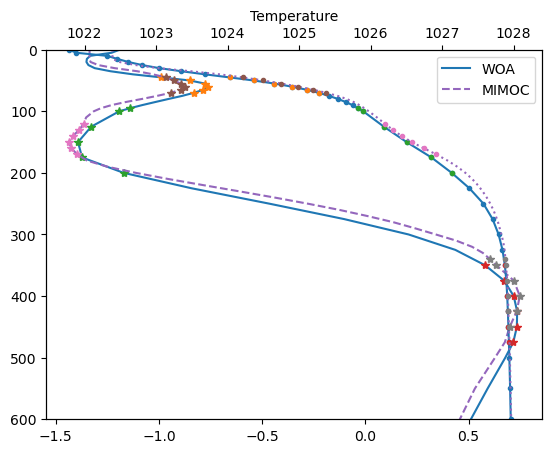

In [25]:
f = plt.figure()
ax = plt.gca()
i_sPW = np.argmax(T[5:20])+5
i_wPW = np.argmin(T[16:24])+16
i_AW = np.argmax(T[24:35])+24
ax.plot(T, dsT.depth.values, label = 'WOA')
ax.plot(T[i_sPW-3:i_sPW+3], dsT.depth.values[i_sPW-3:i_sPW+3], '*')
ax.plot(T[i_wPW-3:i_wPW+3],dsT.depth.values[i_wPW-3:i_wPW+3],  '*')
ax.plot(T[i_AW-3:i_AW+3],dsT.depth.values[i_AW-3:i_AW+3], '*')

ax.plot(T_MIMOC, dsT_MIMOC.PRES.values, '--', label = 'MIMOC')
ax.plot(T_MIMOC[i_sPW_MIMOC-3:i_sPW_MIMOC+3], dsT_MIMOC.PRES.values[i_sPW_MIMOC-3:i_sPW_MIMOC+3], '*')
ax.plot(T_MIMOC[i_wPW_MIMOC-3:i_wPW_MIMOC+3],dsT_MIMOC.PRES.values[i_wPW_MIMOC-3:i_wPW_MIMOC+3],  '*')
ax.plot(T_MIMOC[i_AW_MIMOC-3:i_AW_MIMOC+3],dsT_MIMOC.PRES.values[i_AW_MIMOC-3:i_AW_MIMOC+3], '*')

ax.legend()


ax2 = ax.twiny()
ax2.plot(R0, dsT.depth.values, '.-')
ax2.plot(R0[i_sPW-3:i_sPW+3], dsT.depth.values[i_sPW-3:i_sPW+3], '.')
ax2.plot(R0[i_wPW-3:i_wPW+3],dsT.depth.values[i_wPW-3:i_wPW+3],  '.')
ax2.plot(R0[i_AW-3:i_AW+3],dsT.depth.values[i_AW-3:i_AW+3], '.')

ax2.plot(R0_MIMOC, dsT_MIMOC.PRES.values, ':')
ax2.plot(R0_MIMOC[i_sPW_MIMOC-3:i_sPW_MIMOC+3], dsT_MIMOC.PRES.values[i_sPW_MIMOC-3:i_sPW_MIMOC+3], '.')
ax2.plot(R0_MIMOC[i_wPW_MIMOC-3:i_wPW_MIMOC+3],dsT_MIMOC.PRES.values[i_wPW_MIMOC-3:i_wPW_MIMOC+3],  '.')
ax2.plot(R0_MIMOC[i_AW_MIMOC-3:i_AW_MIMOC+3],dsT_MIMOC.PRES.values[i_AW_MIMOC-3:i_AW_MIMOC+3], '.')

#ax.set_xticklabels([''])


ax = plt.gca()
ax.invert_yaxis()
ax.set_ylim([600, 0])
ax.set_ylabel('Depth [m]')
ax2.set_xlabel('Potential density')
ax.set_xlabel('Temperature')



In [27]:
dssh = xr.open_dataset('/mnt/shackleton/storage3/nplanat/Data_SSH/Final_SSH_ORAS_2.nc')
dsshA = xr.open_dataset('/mnt/shackleton/storage3/nplanat/Data_SSH/Final_SSH_Armi_tot.nc')
dsshM = xr.open_dataset('/mnt/shackleton/storage3/nplanat/Data_SSH/Final2_SSH_mix.nc')

In [16]:
ds_era5 = xr.open_dataset('/mnt/shackleton/storage3/nplanat/'+'Data_ERA5/ERA5sea_level_pressire.nc')
ERA5 = ds_era5.sel(time = slice('2005-01-01', '2017-12-31')).groupby('time.month').mean('time')
MSL = np.flip(ERA5.msl, axis = 0)

## WOA 

In [ ]:
Rho_Vals =np.array([R0[i_sPW], R0[i_wPW], R0[i_AW]])
eps = 3
mid_lat = 78.375
for i in range(12):
    print(i)
    dsT = WOA_M_Q_sigma(ListeT[i], ListeS[i], ListeR[i],  eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))).isel(month = i), Rho_Vals, g_0 = 9.83)
    dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_'+str(int(eps))+'_'+str(int(mid_lat))+'{0:02}'.format(i)+'.nc')
dsT = WOA_M_Q_moy_sigma(ListeT, ListeS, ListeR,  eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))), Rho_Vals,MSL.mean('month'), g_0 = 9.83)
dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_'+str(int(eps))+'_'+str(int(mid_lat))+'_moy.nc')
   

## MIMOC

In [91]:
eps = 3; mid_lat = 78.375

Rho_Vals_MIMOC =np.array([R0_MIMOC[i_sPW_MIMOC], R0_MIMOC[i_wPW_MIMOC], R0_MIMOC[i_AW_MIMOC]])
print(Rho_Vals_MIMOC)
dsT = MIMOC_moy(Liste_MIMOC, eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))), Rho_Vals_MIMOC,  g_0 = 9.83)
dsT.to_netcdf('/storage/nplanat/DataWOA/MIMOC_mix2_'+str(int(eps))+'_'+str(int(mid_lat))+'_moy.nc')


for i in range(12):
    print(i)
    dsT = MIMOC(Liste_MIMOC[i], eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))).isel(month = i), Rho_Vals_MIMOC, g_0 = 9.83)
    dsT.to_netcdf('/storage/nplanat/DataWOA/MIMOC_mix2_'+str(int(eps))+'_'+str(int(mid_lat))+'{0:02}'.format(i)+'.nc')

[1024.98998165 1026.57526886 1027.920515  ]
0
1
2
3
4
5
6
7
8
9
10
11


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


## SSH

In [ ]:
Rho_Vals =np.array([R0[i_sPW], R0[i_wPW], R0[i_AW]])
eps = 3
mid_lat = 78.375
for i in range(12):
    print(i)
    dsT = WOA_M_Q_sigma(ListeT[i], ListeS[i], ListeR[i],  dssh.ssh_A5B7_m.isel(month = i), Rho_Vals, g_0 = 9.83)
    dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_O_SSH'+'{0:02}'.format(i)+'.nc')
dsT = WOA_M_Q_moy_sigma(ListeT, ListeS, ListeR,  dssh.ssh_A5B7_m, Rho_Vals,MSL.mean('month'), g_0 = 9.83)
dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_O_SSH'+'_moy.nc')
   

## WOA sPW sensibility

In [98]:
Rho_Vals = (np.linspace(R0[i_sPW-6], R0[i_sPW+6], 25))
eps = 3
mid_lat = 78.375

print(Rho_Vals)
dsT = WOA_M_Q_moy_sigma(ListeT, ListeS, ListeR,  eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))), Rho_Vals, g_0 = 9.83)
dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_sPW_'+str(int(eps))+'_'+str(int(mid_lat))+'_moy.nc')


for i in range(12):
    print(i)
    dsT = WOA_M_Q_sigma(ListeT[i], ListeS[i], ListeR[i],  eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))).isel(month = i), Rho_Vals, g_0 = 9.83)
    dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_sPW_'+str(int(eps))+'_'+str(int(mid_lat))+'{0:02}'.format(i)+'.nc')
    

[1023.04499861 1023.15757632 1023.27015402 1023.38273173 1023.49530943
 1023.60788714 1023.72046485 1023.83304255 1023.94562026 1024.05819796
 1024.17077567 1024.28335337 1024.39593108 1024.50850879 1024.62108649
 1024.7336642  1024.8462419  1024.95881961 1025.07139731 1025.18397502
 1025.29655273 1025.40913043 1025.52170814 1025.63428584 1025.74686355]


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


0


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


1


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


2


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


3


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


4


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


5


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


6


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


7


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


8


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


9


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


10


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


11


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


## WOA wPW sensitivity

In [18]:
Rho_Vals = (np.linspace(R0[i_wPW-4], R0[i_wPW+4], 25))
eps = 3
mid_lat = 78.375

print(Rho_Vals)
dsT = WOA_M_Q_moy_sigma(ListeT, ListeS, ListeR,  eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))), Rho_Vals, MSL.mean('month'), g_0 = 9.83)
dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_wPW_'+str(int(eps))+'_'+str(int(mid_lat))+'_moy.nc')


for i in range(12):
    print(i)
    dsT = WOA_M_Q_sigma(ListeT[i], ListeS[i], ListeR[i],  eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))).isel(month = i), Rho_Vals, g_0 = 9.83)
    dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_wPW_'+str(int(eps))+'_'+str(int(mid_lat))+'{0:02}'.format(i)+'.nc')
    

[1025.74686355 1025.82314961 1025.89943567 1025.97572172 1026.05200778
 1026.12829384 1026.2045799  1026.28086596 1026.35715201 1026.43343807
 1026.50972413 1026.58601019 1026.66229625 1026.7385823  1026.81486836
 1026.89115442 1026.96744048 1027.04372654 1027.12001259 1027.19629865
 1027.27258471 1027.34887077 1027.42515683 1027.50144289 1027.57772894]


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

0


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

1


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

2


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

3


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

4


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

5


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

6


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

7


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

8


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

9


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

10


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

11


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

## WOA AW sensibility

In [17]:
Rho_Vals = (np.linspace(R0[i_AW-4], R0[i_AW+4], 25))
eps = 3
mid_lat = 78.375

print(Rho_Vals)
dsT = WOA_M_Q_moy_sigma(ListeT, ListeS, ListeR,  eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))), Rho_Vals, MSL.mean('month'), g_0 = 9.83)
dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_AW_'+str(int(eps))+'_'+str(int(mid_lat))+'_moy.nc')


for i in range(12):
    print(i)
    dsT = WOA_M_Q_sigma(ListeT[i], ListeS[i], ListeR[i],  eval('dsshM.ssh_mixed_'+str(int(eps))+'_'+str(int(mid_lat))).isel(month = i), Rho_Vals, g_0 = 9.83)
    dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_mix2_AW_'+str(int(eps))+'_'+str(int(mid_lat))+'{0:02}'.format(i)+'.nc')
    

[1027.84409838 1027.84854876 1027.85299914 1027.85744953 1027.86189991
 1027.8663503  1027.87080068 1027.87525106 1027.87970145 1027.88415183
 1027.88860222 1027.8930526  1027.89750299 1027.90195337 1027.90640375
 1027.91085414 1027.91530452 1027.91975491 1027.92420529 1027.92865568
 1027.93310606 1027.93755644 1027.94200683 1027.94645721 1027.9509076 ]


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

0


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

1


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

2


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

3


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

4


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

5


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

6


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

7


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

8


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

9


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

10


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

11


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwar

## WOA - Armitage

In [29]:
Rho_Vals =np.array([R0[i_sPW], R0[i_wPW], R0[i_AW]])
print(Rho_Vals)
dsT = WOA_M_Q_moy_sigma(ListeT, ListeS, ListeR,  dsshA.ssh_A5B7_m, Rho_Vals, g_0 = 9.83)
dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_sigma_Armitage_moy.nc')

for i in range(12):
    print(i)
    dsT = WOA_M_Q_sigma(ListeT[i], ListeS[i], ListeR[i],  dsshA.ssh_A5B7_m.isel(month = i), Rho_Vals, g_0 = 9.83)
    dsT.to_netcdf('/storage/nplanat/DataWOA/WOA_sigma_Armitage_'+'{0:02}'.format(i)+'.nc')

[1024.89873677 1026.50399557 1027.91942559]


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


0


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


1


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


2


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


3


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


4


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


5


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


6


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


7


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


8


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


9


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


10


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


11


/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/aos/home/nplanat/miniconda3/envs/Analysis2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
